# This demo uses dataset of raw T1 structual MRI images. ABIDE dataset.

573 subjects on control in total.<p>
from 6 to 56 years old.<p>
10% for test, 90% for training.<p>



In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from preprocess import *

## 1. The raw image

### Some images looks like this:

Dimension:  (176, 256, 256)


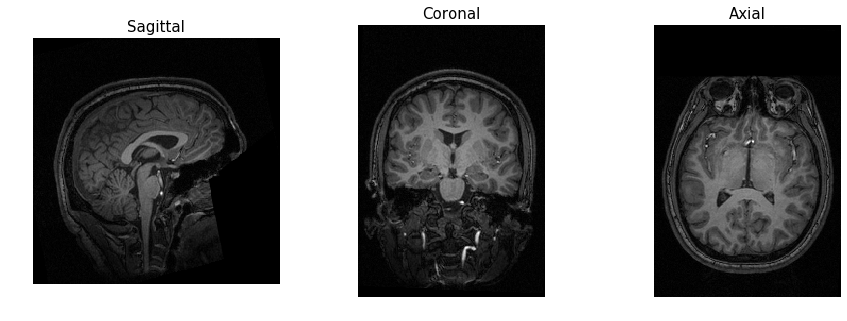

In [4]:
nii_img = nib.load('/media/woody/Elements/age_data/ABIDE_I/anat_data/50002.nii.gz')
npy_img = nii_img.get_data()
print2d(npy_img)

### It goes through the resampling and padding process

Dimension:  (88, 128, 128)


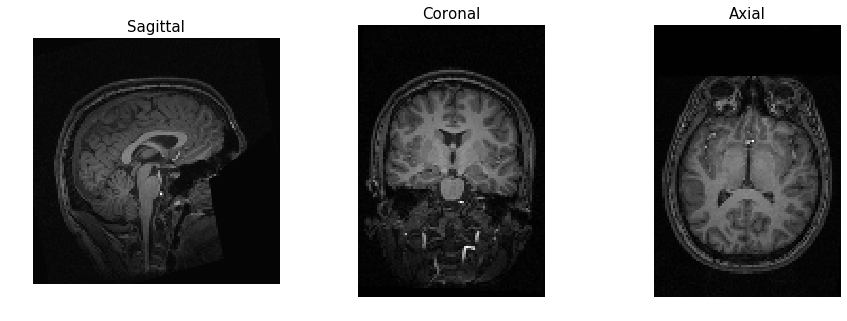

In [5]:
header = nii_img.header
pixdim = np.round(header['pixdim'][1:4])
resampled_img = resample(npy_img, pixdim, [2,2,2])
print2d(resampled_img)

Dimension:  (130, 130, 130)


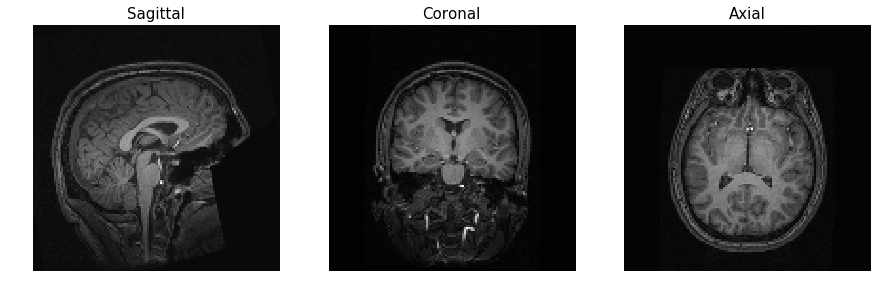

In [6]:
crop_padded_img = np.load('./data_npy/origin/50002.npy')
print2d(crop_padded_img)

### The mean image of all the training data is computed and is subtracted from all training and test data.
### It is worth noting that the test data does not contribute to the mean image. This is because the training data, and only training data, needs to have zero mean for better training performance.
### How does the mean values look like:

Dimension:  (130, 130, 130)


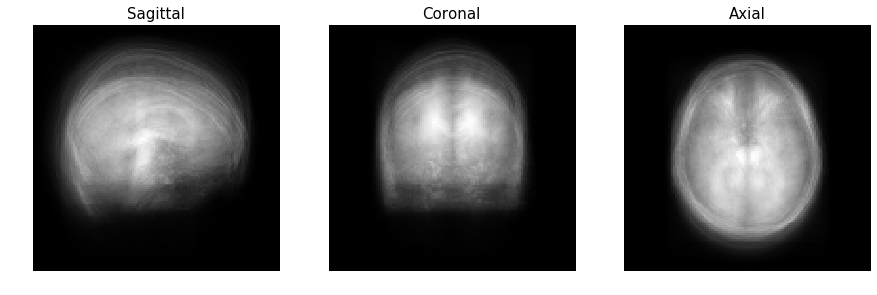

In [7]:
mean_npy = np.load('./data_npy/mean_npy.npy')
print2d(mean_npy)


### Finally, the images fed into the model look like this:

Dimension:  (130, 130, 130)


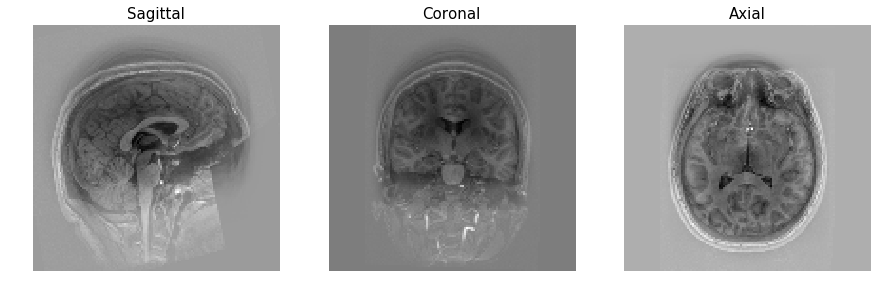

In [8]:
final_img = np.load('./data_npy/mean_subtracted/50002.npy')
print2d(final_img)

## 2. Training and test results
- We collect the best shot who has the smallest loss value (RMSE) in the training process.

- The validation uses the test dataset.

- Our model uses 3D-CNN with dropout, batch normalization and L2 regularization.
- Target model uses 3D-CNN with dropout.

Text(0.5, 1.0, "Target model's trainning loss")

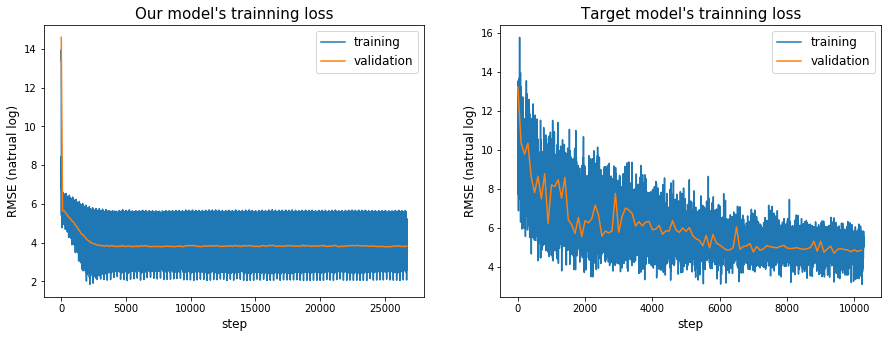

In [10]:
def subdraw(ax,filename):
    arr = np.load(filename)
    ax.plot(arr[0], np.log(arr[1]),label='training')
    ax.plot(arr[2], np.log(arr[3]),label='validation')
    ax.legend(fontsize=12)
    ax.set_xlabel('step',fontsize=12)
    ax.set_ylabel('RMSE (natrual log)',fontsize=12)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
subdraw(ax=ax1,filename='./img/demo_1_1_pltdata_2019.03.19.07:14:05.npy')
ax1.set_title('Our model\'s trainning loss',fontsize=15)
subdraw(ax=ax2,filename='./img/demo_1_2_pltdata_2019.03.19.20:22:06.npy')
ax2.set_title('Target model\'s trainning loss',fontsize=15)

### Let's check the correlation between the predicted age and the chronological age.

Text(0.5, 1.0, "Target model's test result, the correlation")

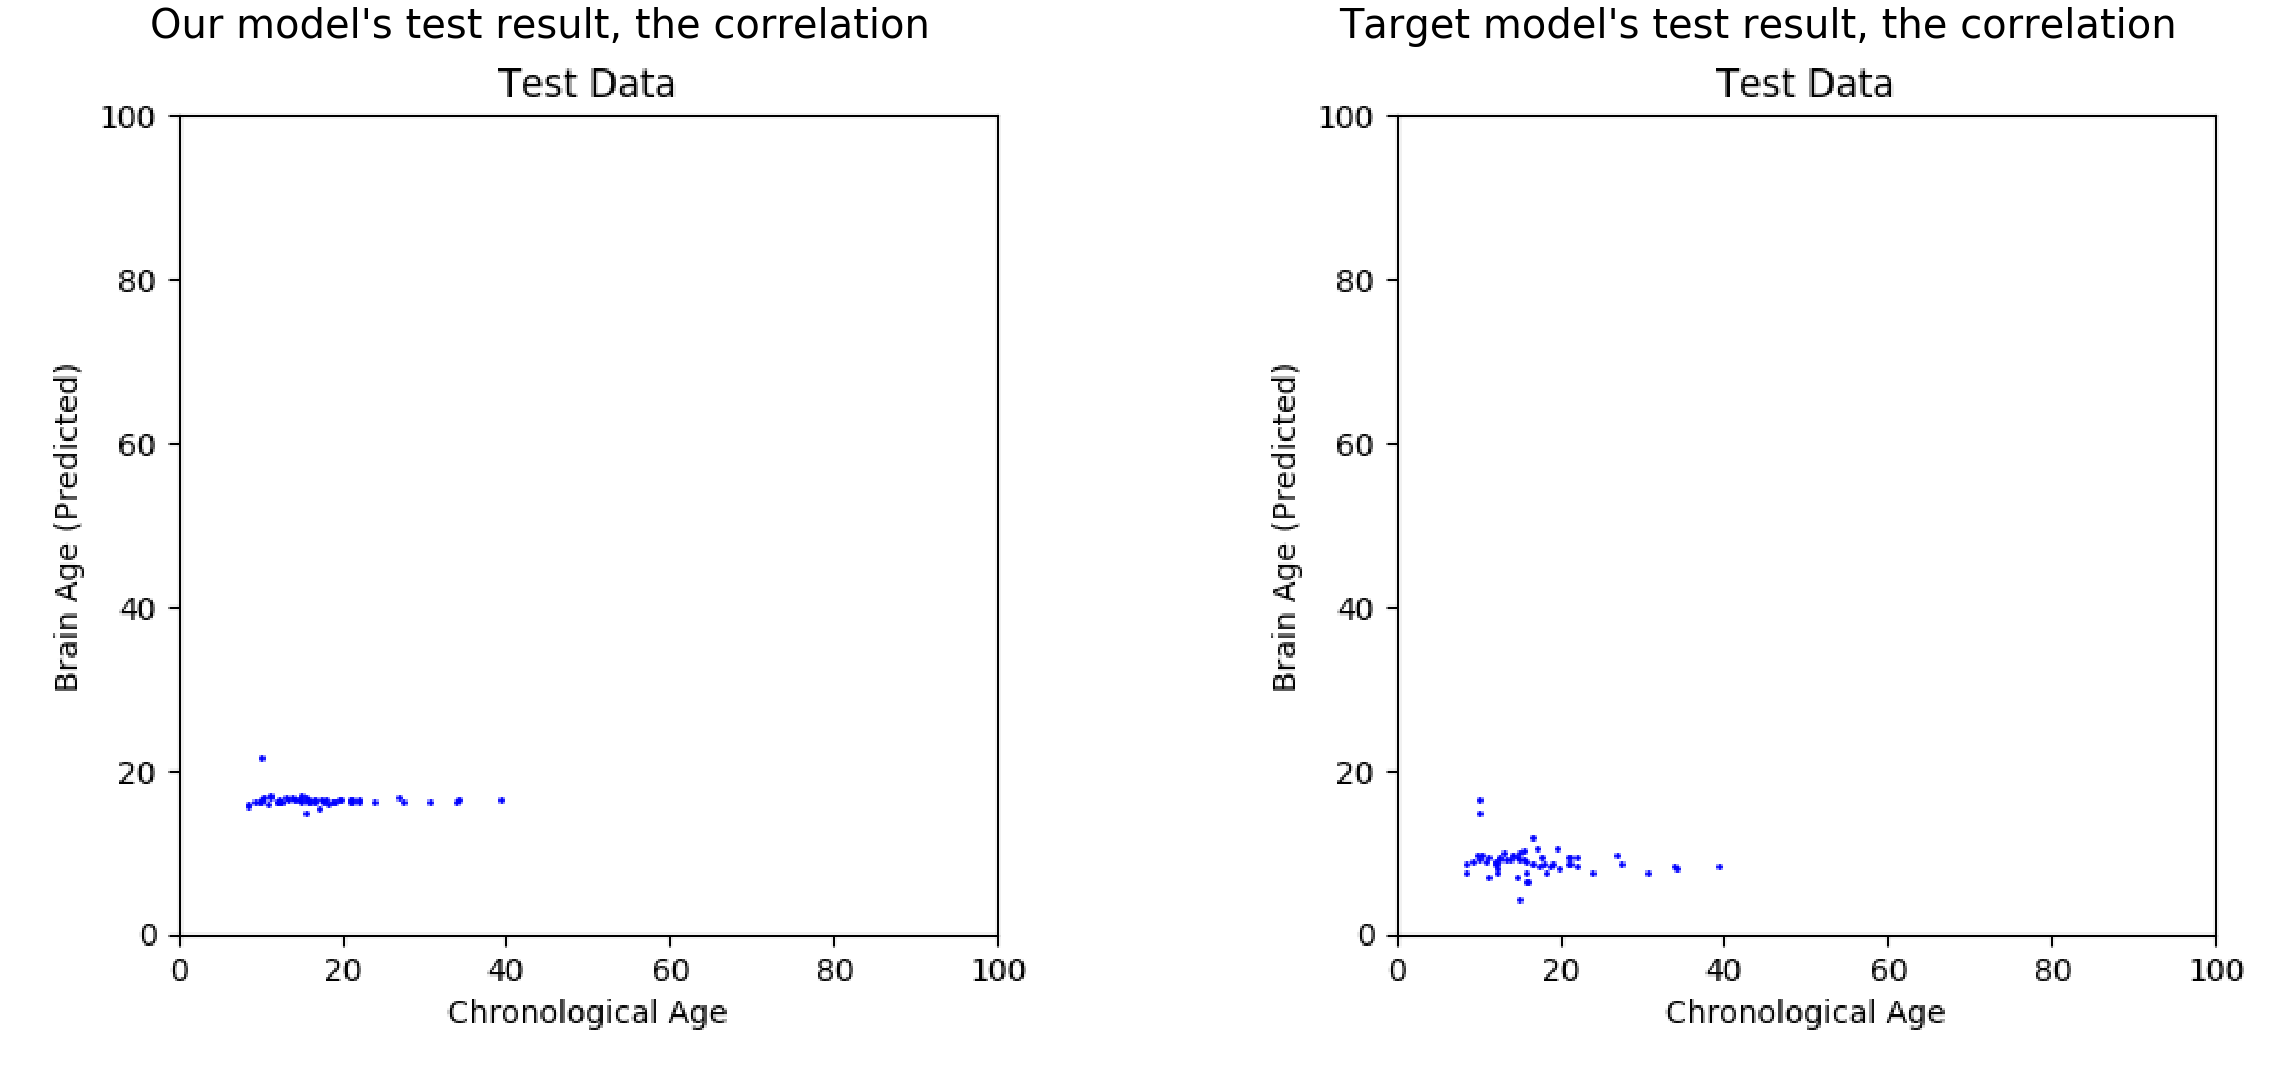

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.imshow(plt.imread('./img/demo_1_1_test.png'))
ax1.axis('off')
ax1.set_title('Our model\'s test result, the correlation',fontsize=40)
ax2.imshow(plt.imread('./img/demo_1_2_test.png'))
ax2.axis('off')
ax2.set_title('Target model\'s test result, the correlation',fontsize=40)

## Conclusion
### It seems there is something wrong with the model code.
### We have to fix the code first.
### Let's figure out where to start with.

## Appendix:
Predicted age of some test subjects.

In [4]:
from preprocess import *
from my_tools import *
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import argparse
import sys


def print_activations(t):
    print(t.op.name, ' ', t.get_shape().as_list())


def inference(X, keep_prob, is_training_forBN, trivial=True):
    l2_loss = 0
    with tf.name_scope('l1_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([5,5,5,1,16], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[16]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(X,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l2_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([3,3,3,16,32], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[32]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l3_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([3,3,3,32,64], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[64]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l4_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([3,3,3,64,64], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[64]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l5_conv3d') as scope:  # temp
        w = tf.Variable(tf.truncated_normal([3,3,3,64,64], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[64]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l6_fc') as scope:
        max_pool_shape = max_pool.get_shape().as_list()
        temp_shape = 1
        for i in max_pool_shape[1:]:
            temp_shape *= i
        fc_input = tf.reshape(max_pool, [-1, temp_shape])
        w = tf.Variable(tf.truncated_normal([temp_shape,512],stddev=0.1),name='w')
        b = tf.Variable(tf.constant(0.1,shape=[512]),name='b')
        temp_output = tf.matmul(fc_input,w) + b
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        fc_out = tf.nn.relu(temp_output, name='fc_out1')
        dropout = tf.nn.dropout(fc_out,keep_prob=keep_prob, name='dropout1')
        
        l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(fc_out)
            print_activations(dropout)
    with tf.name_scope('l7_fc') as scope:
        w = tf.Variable(tf.truncated_normal([512,128],stddev=0.1),name='w')
        b = tf.Variable(tf.constant(0.1,shape=[128]),name='b')
        temp_output = tf.matmul(fc_out,w) + b
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        fc_out = tf.nn.relu(temp_output, name='fc_out2')
        dropout = tf.nn.dropout(fc_out,keep_prob=keep_prob, name='dropout2')
        
        l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(fc_out)
            print_activations(dropout)
    with tf.name_scope('l8_fc') as scope:
        w = tf.Variable(tf.truncated_normal([128,1],stddev=0.1),name='w')
        b = tf.Variable(tf.constant(0.1,shape=[1]),name='b')
        
        final_output = tf.add(tf.matmul(dropout,w), b, name='final_output')
        
        l2_loss += tf.nn.l2_loss(w)

        if trivial:
            print_activations(final_output)
    
    return final_output, l2_loss
        
def get_loss(predict_batches,label_batches,l2_loss):
    with tf.name_scope('cross_entropy'):
        cost = tf.reduce_mean(tf.square(predict_batches - label_batches)) + 1e-6 * l2_loss
    return cost



def test_single_subject(phe_index):
    with tf.Graph().as_default():
        phe = pd.read_csv('./phenotypics.csv', sep=',',header=0)
        sub_id = phe['id'][phe_index]
#         arr = np.load('./data_npy/mean_subtracted/'+sub_id+'.npy')
        arr = np.load('./data_npy/origin/'+str(int(sub_id))+'.npy')
        arr = arr.astype(np.float32)
        arr_shape = arr.shape
        label = phe['age'][phe_index]
        
        tf_arr = tf.placeholder(tf.float32,shape=arr_shape)
        tf_label = tf.placeholder(tf.float32)
        X = tf.reshape(arr, [-1]+list(arr_shape)+[1])
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        
        is_training_forBN = tf.placeholder(tf.bool, name='is_training_forBN')
        
        predicted_age,l2_loss = inference(X,keep_prob,is_training_forBN,trivial=False)

#         loss = get_loss(predicted_age,label_batch,l2_loss)
#         acc = get_accuracy(predicted_age,label_batch)
    
        saver = tf.train.Saver()
#         pdb.set_trace()

        
        with tf.Session() as sess:
            saver.restore(sess, './log/demo1.1_mine_model.ckpt')
#             saver.restore(sess, './backup/demo1.1_mine_model.ckpt')
            print('Model loaded successfully.')
                
            p_age = sess.run(predicted_age,feed_dict={keep_prob:1.0,
                                              is_training_forBN:False,
                                              tf_arr:arr,
                                              tf_label:label})
            print('Subject: ',sub_id,', chronological age is ',label,', predicted age is ',p_age,'.')
    return
for i in range(40):
    test_single_subject(i)

INFO:tensorflow:Restoring parameters from ./log/demo1.1_mine_model.ckpt
Model loaded successfully.
Subject:  51075.0 , chronological age is  14.2 , predicted age is  [[14.720013]] .
INFO:tensorflow:Restoring parameters from ./log/demo1.1_mine_model.ckpt
Model loaded successfully.
Subject:  50562.0 , chronological age is  10.83 , predicted age is  [[14.934543]] .
INFO:tensorflow:Restoring parameters from ./log/demo1.1_mine_model.ckpt
Model loaded successfully.
Subject:  51078.0 , chronological age is  6.47 , predicted age is  [[14.817]] .
INFO:tensorflow:Restoring parameters from ./log/demo1.1_mine_model.ckpt
Model loaded successfully.
Subject:  50656.0 , chronological age is  28.0 , predicted age is  [[15.375941]] .
INFO:tensorflow:Restoring parameters from ./log/demo1.1_mine_model.ckpt
Model loaded successfully.
Subject:  50269.0 , chronological age is  14.66 , predicted age is  [[15.061264]] .
INFO:tensorflow:Restoring parameters from ./log/demo1.1_mine_model.ckpt
Model loaded succes